In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prepare_data import train_loader, val_loader, test_loader



Number of classes: 31
✅ Dataset split completed successfully!
Classes: ['Akshay_Kumar', 'Alexandra_Daddario', 'Alia_Bhatt', 'Amitabh_Bachchan', 'Andy_Samberg', 'Anushka_Sharma', 'Billie_Eilish', 'Brad_Pitt', 'Camila_Cabello', 'Charlize_Theron', 'Claire_Holt', 'Courtney_Cox', 'Dwayne_Johnson', 'Elizabeth_Olsen', 'Ellen_Degeneres', 'Henry_Cavill', 'Hrithik_Roshan', 'Hugh_Jackman', 'Jessica_Alba', 'Kashyap', 'Lisa_Kudrow', 'Margot_Robbie', 'Marmik', 'Natalie_Portman', 'Priyanka_Chopra', 'Robert_Downey_Jr', 'Roger_Federer', 'Tom_Cruise', 'Vijay_Deverakonda', 'Virat_Kohli', 'Zac_Efron']
Number of training images: 2562
Number of validation images: 1742
Number of test images: 1787


In [2]:
device = torch.device("cpu")
print("Using:", device)

model = models.mobilenet_v2(pretrained=True)

# Freeze all feature layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier[1] = nn.Linear(model.last_channel, 31)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)


Using: cpu
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/doaa/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/home/doaa/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/doaa/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13.6M/13.6M [00:09<00:00, 1.48MB/s]


In [9]:
def train(model, train_loader, val_loader, epochs=10):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    all_val_probs = []
    all_val_trues = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        # -------- Training Loop --------
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -------- Validation Loop --------
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_sum = 0

        preds_list = []
        true_list = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()

                # Predictions
                _, preds = torch.max(outputs, 1)
                preds_list.extend(preds.cpu().numpy())
                true_list.extend(labels.cpu().numpy())

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                # ---- Probabilities for ROC/AUC ----
                softmax = torch.nn.Softmax(dim=1)
                probs = softmax(outputs)
                all_val_probs.extend(probs.cpu().numpy())  
                all_val_trues.extend(labels.cpu().numpy())

        val_loss = val_loss_sum / len(val_loader)
        val_acc = val_correct / val_total

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return preds_list, true_list, train_losses, val_losses, train_accs, val_accs, all_val_probs, all_val_trues


In [10]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accs, val_accs):
    plt.figure(figsize=(8,5))
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


In [11]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(trues, preds, num_classes=31):
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_auc(true_labels, probs, num_classes=31):

    # تحويل labels لـ one-hot
    true_bin = label_binarize(true_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(10,8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (One-vs-Rest)")
    plt.legend(loc="lower right", ncol=2, fontsize=8)
    plt.grid()
    plt.show()


In [14]:
preds, trues, train_losses, val_losses, train_accs, val_accs, probs, true_probs = train(model, train_loader, val_loader, epochs=10)



Epoch [1/10] Train Loss: 1.8989, Val Loss: 1.7245 | Train Acc: 0.5250, Val Acc: 0.5832
Epoch [2/10] Train Loss: 1.8259, Val Loss: 1.6357 | Train Acc: 0.5367, Val Acc: 0.6022
Epoch [3/10] Train Loss: 1.7738, Val Loss: 1.5640 | Train Acc: 0.5492, Val Acc: 0.6263
Epoch [4/10] Train Loss: 1.7168, Val Loss: 1.5207 | Train Acc: 0.5660, Val Acc: 0.6073
Epoch [5/10] Train Loss: 1.6847, Val Loss: 1.4982 | Train Acc: 0.5664, Val Acc: 0.6303
Epoch [6/10] Train Loss: 1.6097, Val Loss: 1.4385 | Train Acc: 0.5874, Val Acc: 0.6395
Epoch [7/10] Train Loss: 1.5954, Val Loss: 1.3796 | Train Acc: 0.5738, Val Acc: 0.6418
Epoch [8/10] Train Loss: 1.5766, Val Loss: 1.3493 | Train Acc: 0.5851, Val Acc: 0.6693
Epoch [9/10] Train Loss: 1.4994, Val Loss: 1.3183 | Train Acc: 0.6136, Val Acc: 0.6665
Epoch [10/10] Train Loss: 1.4739, Val Loss: 1.3124 | Train Acc: 0.6054, Val Acc: 0.6619


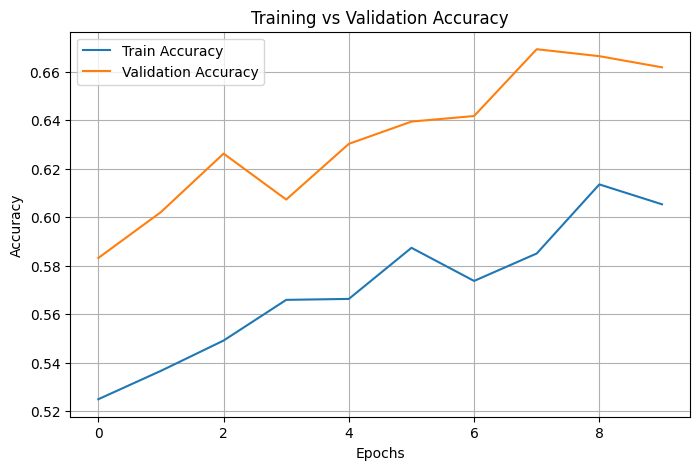

In [15]:
plot_accuracy(train_accs, val_accs)


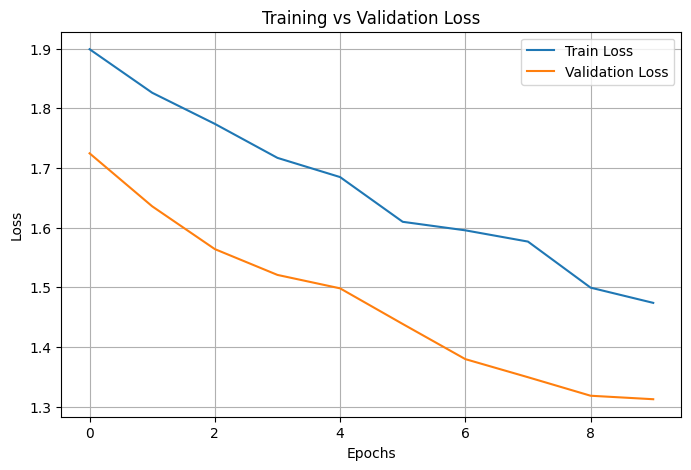

In [16]:
plot_loss(train_losses, val_losses)


In [17]:
plot_roc_auc(true_probs, probs, num_classes=31)


TypeError: list indices must be integers or slices, not tuple

<Figure size 1000x800 with 0 Axes>

In [ ]:
plot_confusion_matrix(trues, preds)
